In [5]:
import keras as keras
import tensorflow as tf
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.utils import pad_sequences
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
class LRHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.lr = []

    def on_epoch_end(self, batch, logs={}):
        optimizer = self.model.optimizer
        lr = keras.backend.get_value(optimizer.lr)
        self.lr.append(lr)

In [7]:
csv_file_path = 'sinusoid_dataset.csv'  # Replace with the actual path to your CSV file
df = pd.read_csv(csv_file_path)
features = df['Feature'].apply(lambda x: np.array([float(val.strip("[]")) for val in x.split()])).values
labels = df['Label'].apply(lambda x: np.array([float(val.strip("[]")) for val in x.split(',')])).values
print(features.shape)
print(labels.shape)

(100000,)
(100000,)


In [8]:
padded_array = pad_sequences(labels, padding='post', maxlen=1)
print(padded_array.shape)
labels = np.vstack(padded_array)
features = np.vstack(features)
#scaler = MinMaxScaler()
#features = scaler.fit_transform(features)

(100000, 1)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train_categorical shape:", y_train.shape)
print("y_test_categorical shape:", y_test.shape)

2023-12-10 12:41:36.542395: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-10 12:41:36.655753: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-10 12:41:36.655840: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-10 12:41:36.659149: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-10 12:41:36.659213: I external/local_xla/xla/stream_executor

X_train shape: (80000, 299)
X_test shape: (20000, 299)
y_train_categorical shape: (80000, 1)
y_test_categorical shape: (20000, 1)


In [10]:
model = keras.Sequential()
model.add(layers.LSTM(299, input_shape=(299, 1), return_sequences=True))
model.add(layers.BatchNormalization())  # Batch normalization can be helpful
model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.BatchNormalization())
model.add(layers.LSTM(64, return_sequences=False))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='tanh'))
model.add(layers.Dense(1))
print(model.summary())

2023-12-10 12:42:22.327861: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 299, 299)          359996    
                                                                 
 batch_normalization (Batch  (None, 299, 299)          1196      
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 299, 128)          219136    
                                                                 
 batch_normalization_1 (Bat  (None, 299, 128)          512       
 chNormalization)                                                
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 batch_normalization_2 (Bat  (None, 64)                2

In [11]:
model.compile(optimizer='adam',
              loss='mean_absolute_error',
              metrics=['mae', 'mse', 'mape'])
overfitCallback = EarlyStopping(monitor='loss', min_delta=0, patience = 4)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-7)
lr_history = LRHistory()
model.fit(X_train_tensor, y_train_tensor, epochs=40, batch_size=256, validation_split=0.2, callbacks=[lr_scheduler, lr_history, overfitCallback])
test_loss, test_mae, test_mse, test_mape = model.evaluate(X_test_tensor, y_test_tensor)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test MAE: {test_mae:.4f}')
print(f'Test MSE: {test_mse:.4f}')
print(f'Test MAPE: {test_mape:.4f}')

Epoch 1/40


2023-12-10 12:42:28.049533: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 76544000 exceeds 10% of free system memory.
2023-12-10 12:42:31.535590: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-10 12:42:32.073482: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa5636c15f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-10 12:42:32.073532: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2023-12-10 12:42:32.079042: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1702230152.169025   49653 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-12-10 12:42:32.942276: W external/loca

250/250 [==============================] - 44s 151ms/step - loss: 41.6030 - mae: 41.6030 - mse: 2506.8823 - mape: 79.3890 - val_loss: 35.7292 - val_mae: 35.7292 - val_mse: 1943.6455 - val_mape: 65.7964 - lr: 0.0010
Epoch 2/40
250/250 [==============================] - 38s 152ms/step - loss: 31.5845 - mae: 31.5845 - mse: 1640.1196 - mape: 54.3954 - val_loss: 28.5027 - val_mae: 28.5027 - val_mse: 1388.2767 - val_mape: 46.4729 - lr: 0.0010
Epoch 3/40
250/250 [==============================] - 39s 155ms/step - loss: 25.3195 - mae: 25.3195 - mse: 1176.6503 - mape: 38.1925 - val_loss: 23.3887 - val_mae: 23.3887 - val_mse: 1000.8645 - val_mape: 35.9937 - lr: 0.0010
Epoch 4/40
250/250 [==============================] - 38s 152ms/step - loss: 20.3978 - mae: 20.3978 - mse: 842.7310 - mape: 29.7302 - val_loss: 18.2880 - val_mae: 18.2880 - val_mse: 709.7169 - val_mape: 26.0526 - lr: 0.0010
Epoch 5/40
250/250 [==============================] - 38s 150ms/step - loss: 16.3076 - mae: 16.3076 - mse: 59

(8, 1)
(8, 299)
[[2.39770275]
 [2.37782306]
 [2.37742957]
 [2.37666683]
 [2.37638921]
 [2.37874752]
 [2.37809528]
 [2.37756972]]
Real Sinusoid Tests:

[[1]]
1/1 [==============================] - 1s 754ms/step
[[1.5843158]]
[[10]]
1/1 [==============================] - 0s 60ms/step
[[8.991657]]
[[19]]
1/1 [==============================] - 0s 63ms/step
[[18.054453]]
[[27]]
1/1 [==============================] - 0s 45ms/step
[[27.597923]]
[[36]]
1/1 [==============================] - 0s 68ms/step
[[36.59767]]
[[45]]
1/1 [==============================] - 0s 69ms/step
[[45.43515]]
[[54]]
1/1 [==============================] - 0s 99ms/step
[[54.40014]]
[[90]]
1/1 [==============================] - 0s 58ms/step
[[90.656]]
Synthetic Sinusoid Tests:

[[51]]
1/1 [==============================] - 0s 31ms/step
[[51.110054]]
[[54]]
1/1 [==============================] - 0s 70ms/step
[[53.964554]]
[[7]]
1/1 [==============================] - 0s 51ms/step
[[6.935612]]
[[16]]
1/1 [================

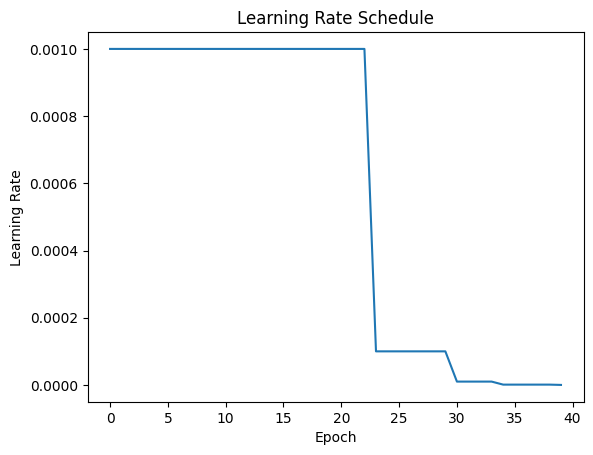

In [12]:
plt.plot(lr_history.lr)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')

# Save the figure
plt.savefig('learning_rate_schedule.png', dpi=300, bbox_inches='tight')
csv_file_path = 'samplesreal.csv'  # Replace with the actual path to your CSV file
df = pd.read_csv(csv_file_path)

# Extract features and labels
features = df['Feature'].apply(lambda x: np.array([float(val.strip("[]")) for val in x.split(',')])).values

# Convert the string of up to 5 numbers to a NumPy array of floats
labels = df['Label'].values
labels = np.vstack(labels)
features = np.vstack(features)

print(labels.shape)
print(features.shape)

means = np.mean(features, axis=1, keepdims=True)
print(means)
features = features - means
#change to 50
features = features * 50
print("Real Sinusoid Tests:\n")
for i in range(8):
  print(labels[i:i+1])
  print(model.predict(features[i:i+1]))
print("Synthetic Sinusoid Tests:\n")
for i in range(100):
  print(y_test[i:i+1])
  print(model.predict(X_test[i:i+1]))